# To do:

- Use the Atlantic Causal Inference Conference Simulations
- data starvation experiment

In [47]:
library(Matching)
library(plyr)
library(tidyverse)
library(stringr)
library(magrittr)
library(caret)
library(rlang)
source("src/simulation_scenarios.R")
source("src/hte_caret.R")
source("src/hte_cv.R")
source("src/eval_hte_cv.R")
# detach("package:plyr", unload=TRUE)

In [48]:
model = list(list(method="xgbTree",
             tune_grid=expand.grid(nrounds = seq(1,501,10), max_depth = c(2), eta = 0.2)))
# model = list(list(method="enet",
#              tune_grid=expand.grid(fraction = 0.5, lambda=exp(seq(-5,2,0.1)))))
DGP = DGPs[[5]]
training_percent = 0.5
n_folds = 5
rep = 1
n = 100

data_stuff = setup_data(DGP, n, training_percent, n_folds)
estimate_stuff = data_stuff %$% get_estimates(data, model, cv_index, test_index, aux_data)
error_stuff = estimate_stuff %$% get_errors(cv_estimates, test_estimates)

In [45]:
cv_estimates %>% tail

,subject,model,treatment,outcome,est_effect,est_outcome,fold,true_mean,true_effect,true_propensity,match,ip_weights
1795,50,enet~0.5~0.0183156388887342,TRUE,5.391379,-1.115138,3.672549,Fold5,4.440757,-1.375533,0.5,33,2
1796,50,enet~0.5~0.0149955768204777,TRUE,5.391379,-1.114089,3.680043,Fold5,4.440757,-1.375533,0.5,33,2
1797,50,enet~0.5~0.0122773399030684,TRUE,5.391379,-1.113287,3.686228,Fold5,4.440757,-1.375533,0.5,33,2
1798,50,enet~0.5~0.0100518357446336,TRUE,5.391379,-1.112671,3.691324,Fold5,4.440757,-1.375533,0.5,33,2
1799,50,enet~0.5~0.00822974704902003,TRUE,5.391379,-1.112196,3.695517,Fold5,4.440757,-1.375533,0.5,33,2
1800,50,enet~0.5~0.00673794699908547,TRUE,5.391379,-1.111827,3.698964,Fold5,4.440757,-1.375533,0.5,33,2


## plot

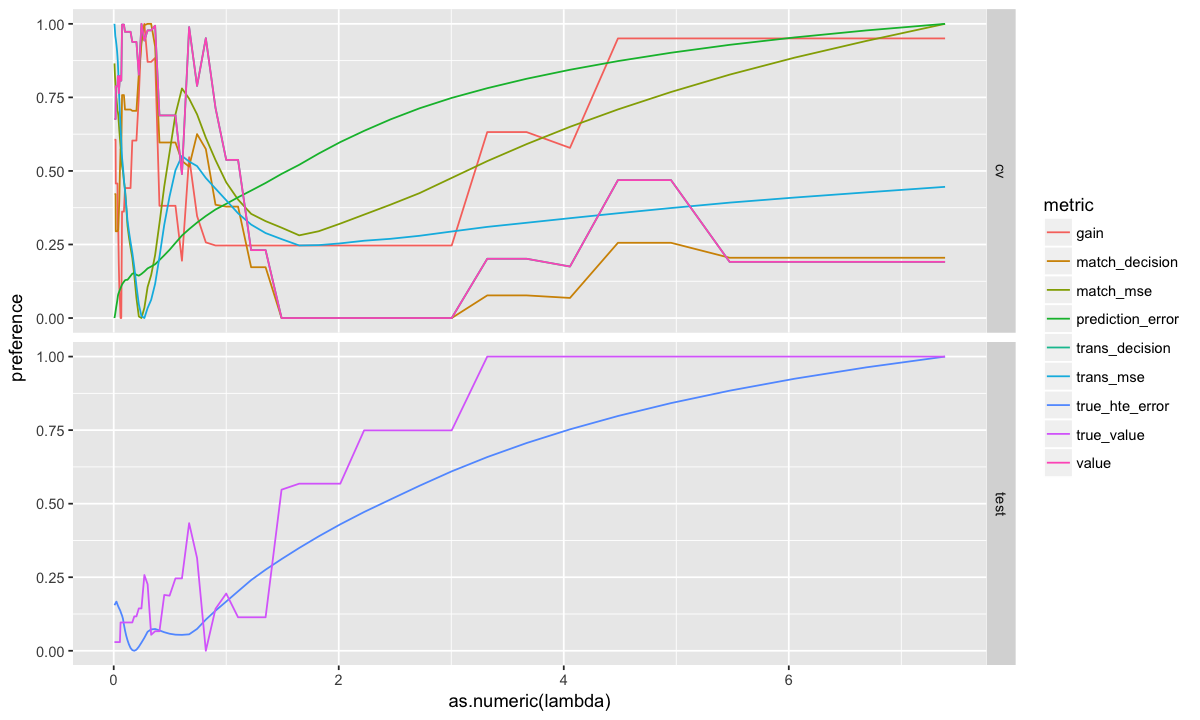

In [127]:
options(repr.plot.width=10, repr.plot.height=6)

cv_plot = error_stuff$cv_error %>%
    separate(model, model %$% c(method, names(tune_grid)), sep="~") %>%
    rename(metric=selection_method) %>%
    group_by(metric) %>%
    mutate(preference = (error - min(error, na.rm=T))/(max(error, na.rm=T)-min(error, na.rm=T))) %>%
    mutate(evaluation = "cv") 

# ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
#     geom_line(aes(color=metric)) 

test_plot = error_stuff$test_error %>% 
    separate(model, model %$% c(method, names(tune_grid)), sep="~") %>%
    gather(metric, error, true_hte_error, true_value) %>%
    group_by(metric) %>%
    mutate(preference = (error - min(error))/(max(error)-min(error))) %>%
    mutate(evaluation = "test")

# # ggplot(aes(x=as.numeric(nrounds), y=preference)) + 
# #     geom_line(aes(color=metric), size=3) 

cv_plot %>% bind_rows(test_plot) %>%
ggplot(aes(x=as.numeric(lambda), y=preference)) + 
    geom_line(aes(color=metric)) + 
    facet_grid(evaluation~.)

In [128]:
error_stuff$true_selection_error %>% arrange(-true_hte_error) %>% data.frame

,model,selection_method,true_hte_error,true_value
1,enet~0.5~3.00416602394643,trans_decision,5.608162,-0.1050844
2,enet~0.5~2.71828182845905,value,5.413855,-0.1050844
3,enet~0.5~1.49182469764127,match_decision,4.425453,-0.1698872
4,enet~0.5~0.00673794699908547,prediction_error,3.804592,-0.336379
5,enet~0.5~0.060810062625218,gain,3.719594,-0.3149411
6,enet~0.5~0.272531793034013,trans_mse,3.36506,-0.2631054
7,enet~0.5~0.246596963941606,match_mse,3.29991,-0.2995711


In [49]:
loop_test = function(DGP, n, n_folds, training_percent, rep, model) {

    errors = setup_data(DGP$DGP, n, training_percent, n_folds) %$%
        get_estimates(data, model, cv_index, test_index, aux_data) %$% 
        get_errors(cv_estimates, test_estimates) 
    true_selection_error = errors$true_selection_error %>%
        mutate(DGP=DGP$name, n_folds=n_folds, training_percent=training_percent, rep=rep)
    
    return(true_selection_error)
}

In [52]:
methods = list("xgbTree",
               "enet")
tune_grids = list(expand.grid(nrounds = seq(1,501,50), max_depth = c(3), eta = 0.2),
                  expand.grid(fraction = 0.5, lambda=exp(seq(-5,2,0.2))))

models = list(methods, tune_grids) %>%
    pmap(~list(method=.x, tune_grid=.y))

simulation_params = list(DGP = unbiased_DGPs[1:3] %>% imap(~list(name=.y, DGP=.x)),
                         n = 100,
                         n_folds=3,
                         training_percent=0.5,
                         rep = 1:3) %>%
cross

In [53]:
results = simulation_params %>% 
    map(~loop_test(.$DGP, .$n, .$n_folds, .$training_percent, .$rep, models)) %>%
    bind_rows

In [55]:
processed_results = results %>%
    group_by(DGP, rep) %>% 
    mutate(rel_value = true_value/max(true_value, rm.na=T),
#        rel_value_opt = true_deficiency/optimal_deficiency,
       rel_increased_error = true_hte_error/min(true_hte_error, rm.na=T))

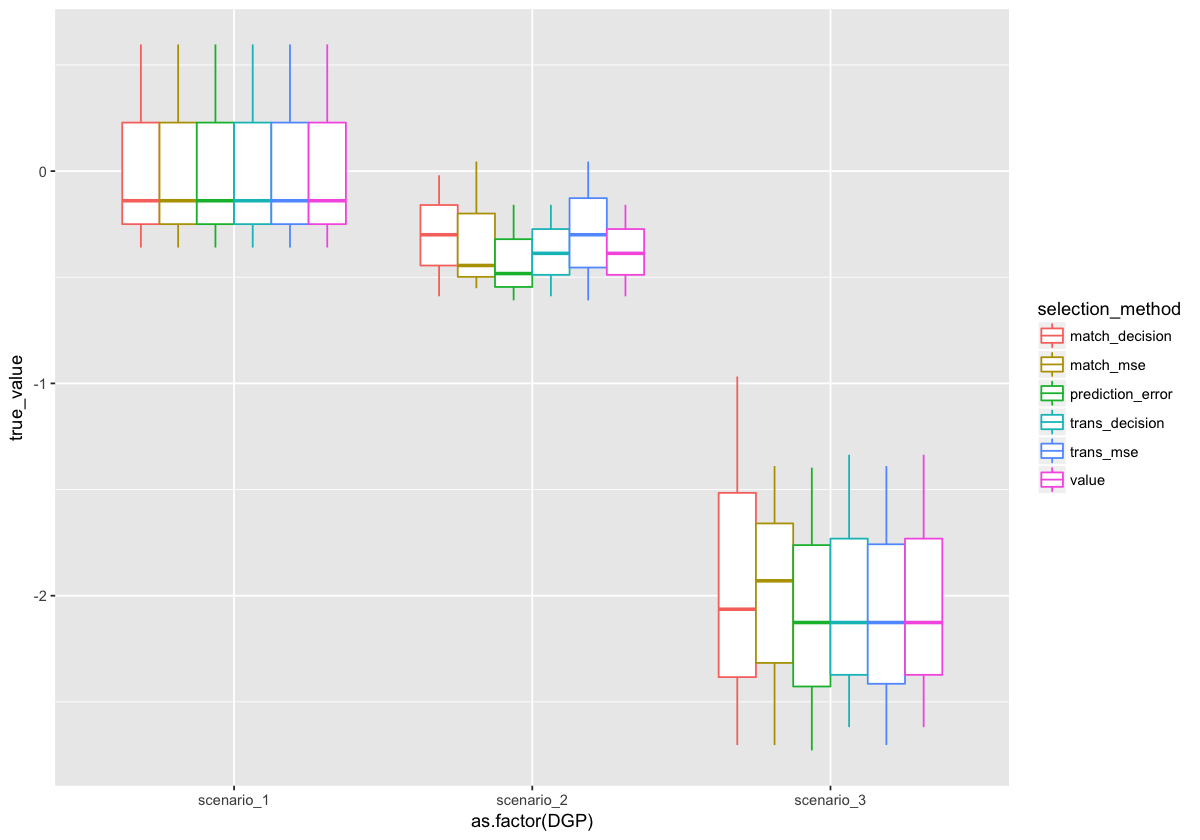

In [57]:
options(repr.plot.width=10, repr.plot.height=7)
processed_results %>%
ggplot(aes(x=as.factor(DGP), y=true_value, color=selection_method)) +
    geom_boxplot()

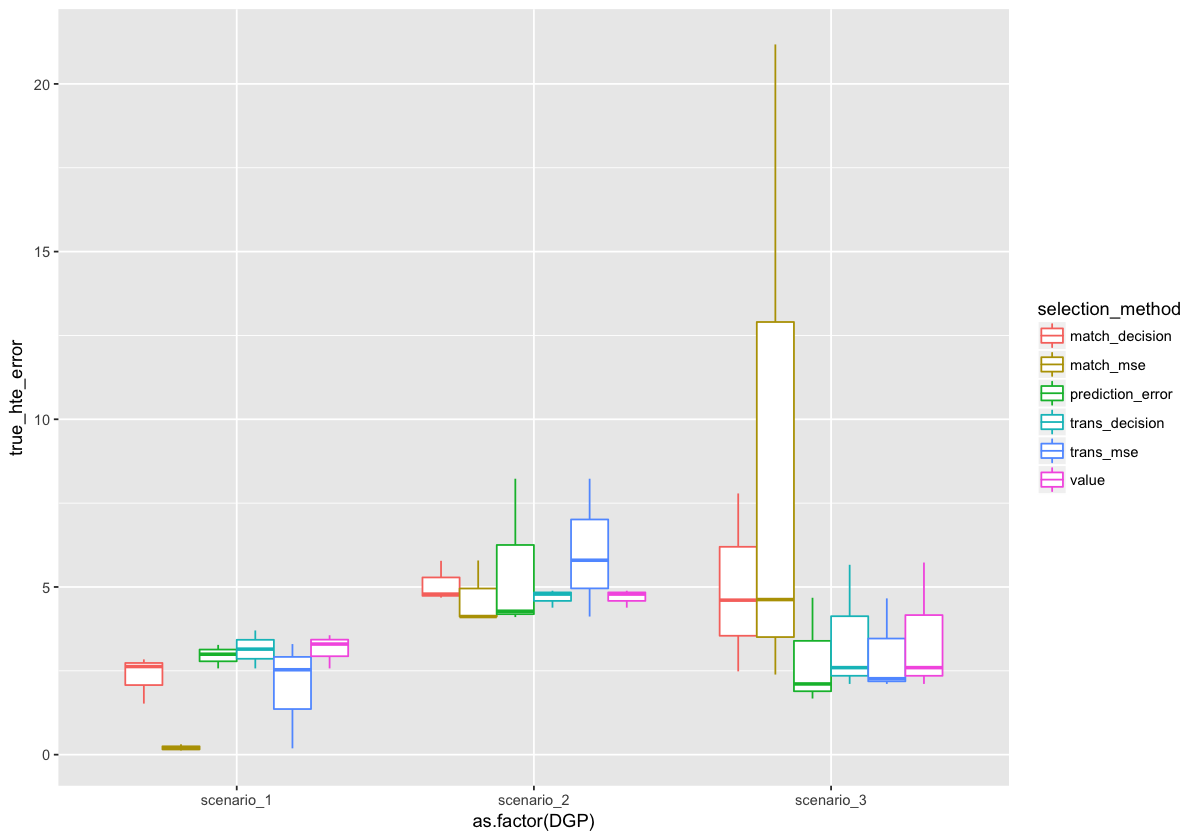

In [58]:
options(repr.plot.width=10, repr.plot.height=7)
results %>%
ggplot(aes(x=as.factor(DGP), y=true_hte_error, color=selection_method)) +
    geom_boxplot()